## CellPhoneDB installation

- `git clone https://github.com/stefanpeidli/cellphonedb` (contains Python interface for stat. analysis test)
- move this notebook into `cellphonedb` directory

# Imports

In [29]:
import sys
import cloudpickle as pickle
from time import process_time
from collections import defaultdict

from scipy.stats import pearsonr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
import scvelo as scv
import seaborn as sns

# !pip install sqlalchemy fbpca geosketch werkzeug
sys.path.insert(0, './cellphonedb/src/api_endpoints/terminal_api/method_terminal_api_endpoints/')
from method_terminal_commands import statistical_analysis

# Utility

## Functions

In [2]:
def save_data(adata):
    df_expr_matrix = adata.raw.X
    df_expr_matrix = df_expr_matrix.T
    df_expr_matrix = pd.DataFrame(df_expr_matrix)

    df_expr_matrix.columns= adata.obs.index
    df_expr_matrix.set_index(adata.raw.var.index, inplace=True) 
    df_expr_matrix.to_csv('counts.txt', sep='\t')
    
    df_meta = pd.DataFrame(data={'Cell': list(adata.obs_names), 'cell_type': list(adata.obs['Clusters'])})
    df_meta.set_index('Cell', inplace=True)
    df_meta.to_csv('meta.txt', sep='\t')

## Constants

In [3]:
n_genes = (1000, 5000, 10000, 15000, 20000, 25000, 30000, 32738)
n_jobs = 32  # used for CellPhoneDB
n_perms = 1000
n_tests = 10
threshold = 0.1
cluster_key = 'Clusters'

# Load the data

In [4]:
adata = scv.datasets.forebrain()  # human forebrain development
adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
adata.var_names_make_unique()
adata.X = adata.X.A  # densify
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Normalize and create `.raw`.

In [5]:
sc.pp.normalize_per_cell(adata)
adata.raw = adata.copy()

Create gene splits.

In [6]:
rs = np.random.RandomState(seed=42)
geness = [rs.choice(adata.var_names, size=n_gene, replace=False) for n_gene in n_genes]

# Run the statistical analysis

## CellPhoneDB

In [7]:
mean_results = defaultdict(lambda: defaultdict(dict))  # method - n_genes - split
pval_results = defaultdict(lambda: defaultdict(dict))
time_results = defaultdict(lambda: defaultdict(dict))

In [ ]:
for genes in geness:
    print(len(genes))
    for i in range(n_tests):
        print(i)
        bdata = adata[:, genes].copy()
        save_data(bdata)

        start_t = process_time()
        statistical_analysis(
            meta_filename='meta.txt', counts_filename='counts.txt', threshold=threshold, threads=n_jobs,
            debug_seed=0, iterations=n_perms, result_precision='4', output_path='out',
            counts_data='gene_name'
        )
        duration = process_time() - start_t
        
        pval_results['cellphonedb'][bdata.n_vars][i] = pd.read_csv('out/pvalues.csv')
        mean_results['cellphonedb'][bdata.n_vars][i] = pd.read_csv('out/means.csv')
        time_results['cellphonedb'][bdata.n_vars][i] = duration

1000
0
[ ][APP][10/06/21-19:21:14][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][10/06/21-19:21:14][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][10/06/21-19:21:14][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][10/06/21-19:21:14][INFO] Using custom database at /home/marius.lange/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][10/06/21-19:21:14][INFO] Launching Method cpdb_statistical_analysis_local_method_launcher
[ ][APP][10/06/21-19:21:14][INFO] Launching Method _set_paths
[ ][APP][10/06/21-19:21:14][WARNING] Output directory (out) exist and is not empty. Result can overwrite old results
[ ][APP][10/06/21-19:21:14][INFO] Launching Method _load_meta_counts
[ ][CORE][10/06/21-19:21:19][INFO] Launching Method cpdb_statistical_analysis_launcher
[ ][CORE][10/06/21-19:21:19][INFO] Launching Method _counts_validations
[ ][CORE][10/06/21-19:21:20][INFO] [Cluster Statistical Analysis Simple] Threshold:0.1 Iterations:1000 D

In [11]:
1

1

## Squidpy's reimplementation of CellPhoneDB

In [14]:
for genes in geness:
    print(len(genes))
    for i in range(n_tests):
        print(i)
        bdata = adata[:, genes].copy()

        start_t = process_time()
        res = sq.gr.ligrec(
            adata,
            n_perms=n_perms,
            threshold=threshold,
            cluster_key="Clusters",
            copy=True,
            use_raw=False,
            show_progress_bar=False,
            interactions_params={'resources': 'CellPhoneDB'},
            transmitter_params={"categories": "ligand"},
            receiver_params={"categories": "receptor"},
            numba_parallel=False,
            n_jobs=n_jobs,
        )
        duration = process_time() - start_t
        
        pval_results['squidpy'][bdata.n_vars][i] = res['pvalues']
        mean_results['squidpy'][bdata.n_vars][i] = res['means']
        time_results['squidpy'][bdata.n_vars][i] = duration

1000
0
1
2
3
4
5
6
7
8
9
5000
0
1
2
3
4
5
6
7
8
9
10000
0
1
2
3
4
5
6
7
8
9
15000
0
1
2
3
4
5
6
7
8
9
20000
0
1
2
3
4
5
6
7
8
9
25000
0
1
2
3
4
5
6
7
8
9
30000
0
1
2
3
4
5
6
7
8
9
32738
0
1
2
3
4
5
6
7
8
9


# Save the results

In [15]:
dfs = []
for meth, split in time_results.items():
    tmp = pd.DataFrame(split)
    mean, std = tmp.mean(), tmp.std()
    ms = pd.DataFrame([[val for pair in zip(mean, std) for val in pair]],
                      columns=[f"{c} {k}" for c in mean.index for k in ["mean", "std"]],
                      index=[meth])
    dfs.append(ms)
    
df = pd.concat(dfs)
df

,1000 mean,1000 std,5000 mean,5000 std,10000 mean,10000 std,15000 mean,15000 std,20000 mean,20000 std,25000 mean,25000 std,30000 mean,30000 std,32738 mean,32738 std
cellphonedb,46.280038,0.556732,46.311221,0.175830,47.706355,0.918247,47.065461,0.329825,47.486354,0.303480,48.243915,1.126305,49.257629,1.526604,48.160418,0.631258
squidpy,4.896481,0.113713,4.918017,0.069355,4.920380,0.099889,4.965470,0.133249,4.987507,0.067842,5.025627,0.067959,5.044292,0.106616,5.040181,0.084975


In [16]:
with open("resuls.pickle", "wb") as fout:
    pickle.dump((pval_results, mean_results, time_results, df), fout)

In [4]:
with open("resuls.pickle", "rb") as fin:
    pvals_results, mean_results, time_results, df = pickle.load(fin)

# Plot the average runtimes

In [36]:
dff = df.iloc[:, ::2]
dff

,1000 mean,5000 mean,10000 mean,15000 mean,20000 mean,25000 mean,30000 mean,32738 mean
cellphonedb,46.280038,46.311221,47.706355,47.065461,47.486354,48.243915,49.257629,48.160418
squidpy,4.896481,4.918017,4.920380,4.965470,4.987507,5.025627,5.044292,5.040181


In [38]:
dff = pd.DataFrame({"runtime": np.r_[dff.values[1], dff.values[0]],
                    "algorithm": ["Squidpy"] * len(dff.T) + ["CellPhoneDB"] * len(dff.T),
                    "#genes": [1000, 5000, 10000, 15000, 20000, 25000, 30000, 32738] * 2})

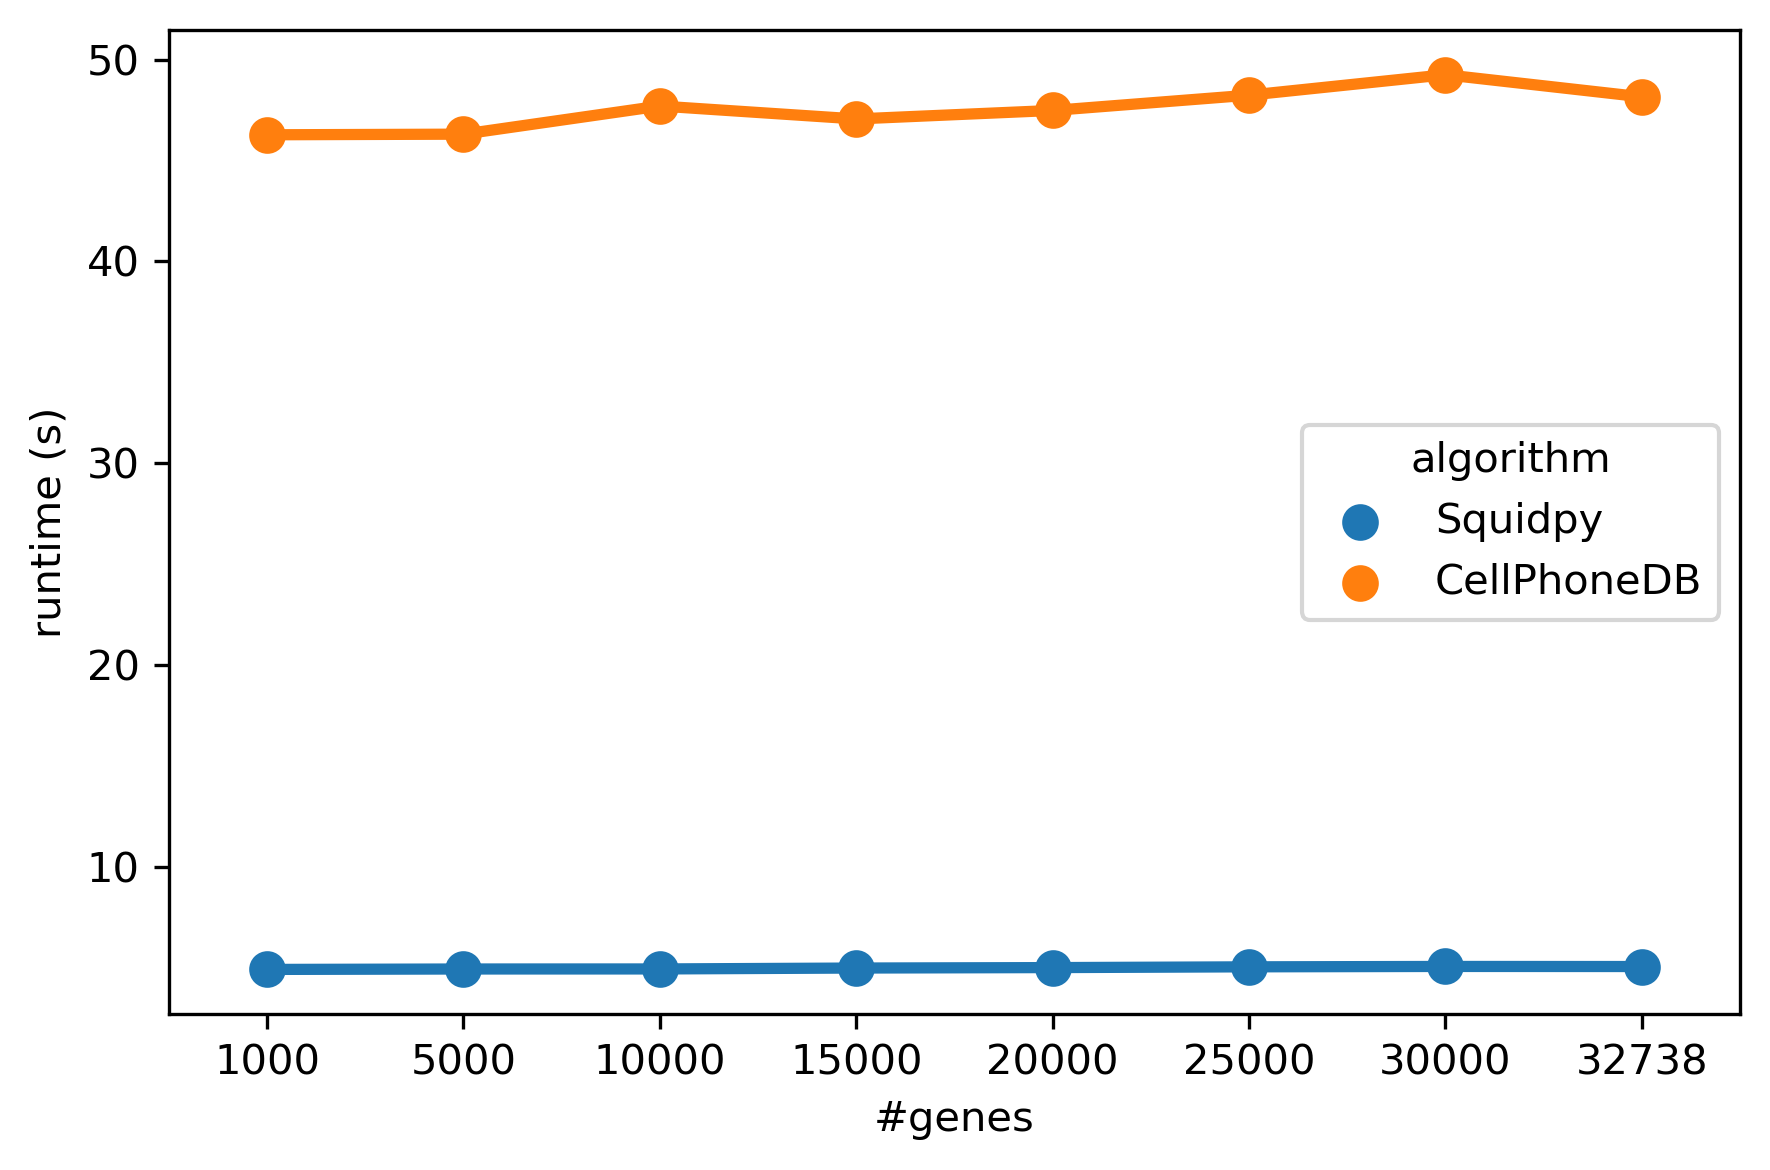

In [39]:
fig, ax = plt.subplots(tight_layout=True, dpi=300)
sns.pointplot(x='#genes', y='runtime', hue="algorithm", data=dff,
                linewidth=1,
                ax=ax,
                palette=None)
ax.set_ylabel("runtime (s)")
fig.savefig("ligrec_runtime.png")